###  Visualize the model parameters distributions for each layer, to check the pruned weights

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from copy import deepcopy
import numpy as np
import sys
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [2]:
from pathlib import Path
from importlib import import_module
import os

# Path to the parent directory
parent_directory_path = Path.cwd().parent  # Adjust this path as necessary

# Iterate through each child directory in the parent directory
for child in parent_directory_path.iterdir():
    if child.is_dir():  # Make sure it's a directory
        sys.path.append(str(child))

# For each child directory in the parent directory
for child in parent_directory_path.iterdir():
    if child.is_dir():  # Make sure it's a directory
        # List all .py files in the directory
        for file in child.glob('*.py'):
            # Import the module
            # Note: os.path.splitext(file.name)[0] gets the module name without the .py extension
            module_name = os.path.splitext(file.name)[0]
            imported_module = import_module(module_name)
            print(f"Imported {module_name} from {child.name}")

Imported pretrain_models from train
Imported ssl_model_pruning from prune
Imported ntl-prune from prune
Imported admm from prune
Imported prune_encoder from prune
Imported pruner from prune
Imported pruning_utils from prune
Imported __init__ from prune
Imported admm_encoder from prune
Imported prune_model from prune
Imported syn from utils
Imported similarity from utils


ImportError: attempted relative import with no known parent package

In [3]:
from models.encoders import ResNetEncoder, ResNetClassifier
from prune.pruner import load_base_model
from metrics.LogME import LogME
from metrics.SFDA import SFDA_Score

### Load the imagenet models

In [4]:
# Load the backbone model
num_classes = 10
model = torchvision.models.resnet50(pretrained=True)
# change the output layer to 10 classes (for digits dataset)
model.fc = nn.Linear(2048, num_classes)

/home/ruyi/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruyi/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Subset

In [107]:
image_size  = 224
batch_size = 1000

# set random seed
torch.manual_seed(0)
np.random.seed(0)


def get_imagenette_dataloader(ratio=1.0):
    # Define transformations

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Create train and test dataset and dataloader
    data_path = "../../data/" + "imagenette2/train"
    train_dataset = ImageFolder(root=data_path, transform=transform)

    # Define the size of the subset
    subset_size = int(len(train_dataset)*ratio)
    print(f"Using sample size of {subset_size}.")
                      
    # Create a random subset for training
    indices = np.random.permutation(len(train_dataset))
    train_indices = indices[:subset_size]
    train_subset = Subset(train_dataset, train_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False, num_workers=2)

    data_path = "../../data/" + "imagenette2/val"
    test_dataset = ImageFolder(root=data_path, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

def get_imagewoof_dataloader(ratio=1.0):
    # Define transformations

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Create train and test dataset and dataloader
    data_path = "../../data/" + "imagewoof2/train"
    train_dataset = ImageFolder(root=data_path, transform=transform)
    # Define the size of the subset
    subset_size = int(len(train_dataset)*ratio)
    print(f"Using sample size of {subset_size}.")
                      
    # Create a random subset for training
    indices = np.random.permutation(len(train_dataset))
    train_indices = indices[:subset_size]
    train_subset = Subset(train_dataset, train_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    data_path = "../../data/" + "imagewoof2/val"
    test_dataset = ImageFolder(root=data_path, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

In [108]:
source_domain = 'imagenette'
target_domain = 'imagewoof'
ratio = 1.0

if source_domain == 'imagenette':
    train_loader_source, test_loader_source = get_imagenette_dataloader(ratio)
else:
    train_loader_source, test_loader_source = get_imagewoof_dataloader(ratio)

if target_domain == 'imagenette':
    train_loader_target, test_loader_target = get_imagenette_dataloader(ratio)
else:
    train_loader_target, test_loader_target = get_imagewoof_dataloader(ratio)

Using sample size of 9469.
Using sample size of 9025.


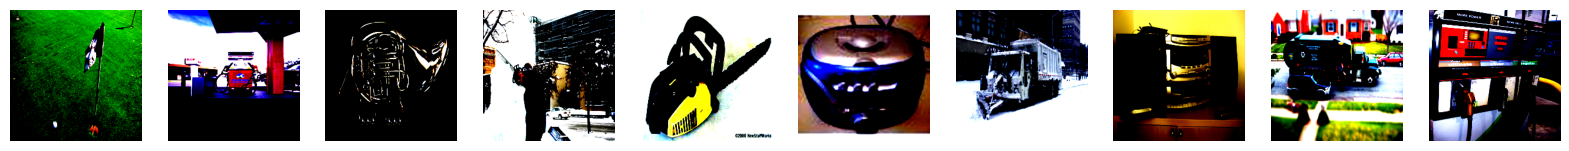

In [109]:
# Visualize samples in these datasets
import matplotlib.pyplot as plt

# Show 10 the images for from imagenette
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for ax, (image, label) in zip(axes, train_loader_source.dataset):
    # clip 
    image = torch.clamp(image, 0, 1)
    ax.imshow(image.permute(1, 2, 0))
    ax.axis('off')
plt.show()



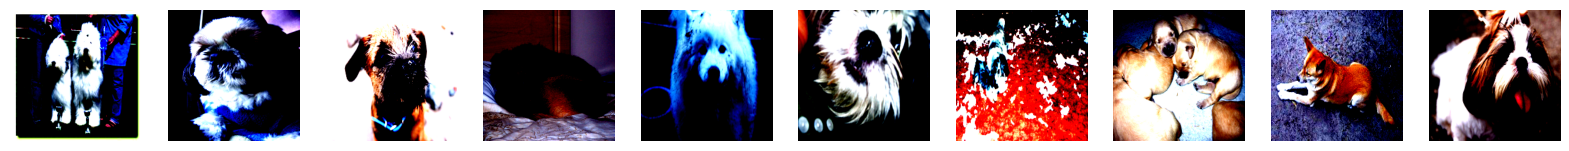

In [110]:
# Show 10 the images for from imagenette
fig, axes = plt.subplots(1, 10, figsize=(20, 5))
for ax, (image, label) in zip(axes, train_loader_target.dataset):
    # clip 
    image = torch.clamp(image, 0, 1)
    ax.imshow(image.permute(1, 2, 0))
    ax.axis('off')
plt.show()


In [111]:
def load_org_source_model():
    # Load the pretrained model (original model on the source domain)
    arch = 'resnet18'
    model = torchvision.models.resnet18(pretrained=False).cuda()
    model.fc = nn.Linear(512, num_classes)

    base_model_dir = f'../../base_models/{arch}-{source_domain}.pth'
    print('Loading the base model from {}'.format(base_model_dir))
    model.load_state_dict(torch.load(base_model_dir))

    resnet_encoder = ResNetEncoder(model)
    resnet_classifier = ResNetClassifier(model, num_classes)

    mask_dict ={}
    for name, param in resnet_encoder.named_parameters():
        mask_dict[name] = torch.ones_like(param)
    return resnet_encoder, resnet_classifier, mask_dict


In [112]:
def load_org_target_model():
    # Load the pretrained model (original model on the source domain)
    arch = 'resnet18'
    model = torchvision.models.resnet18(pretrained=False).cuda()
    model.fc = nn.Linear(512, num_classes)

    base_model_dir = f'../../base_models/{arch}-{target_domain}.pth'
    print('Loading the base model from {}'.format(base_model_dir))
    model.load_state_dict(torch.load(base_model_dir))

    resnet_encoder = ResNetEncoder(model)
    resnet_classifier = ResNetClassifier(model, num_classes)

    mask_dict ={}
    for name, param in resnet_encoder.named_parameters():
        mask_dict[name] = torch.ones_like(param)
    return resnet_encoder, resnet_classifier, mask_dict

In [113]:
def load_ntp_source_to_target_model():
    # Load the NTP pruned model
    arch = 'resnet18'
    seed=2
    sparsity=0.80
    encoder_path = f'../../saved_models/{arch}/admm-lda/{source_domain}_to_{target_domain}/{seed}/{sparsity}/admm_encoder.pth'
    classifier_path = f'../../saved_models/{arch}/admm-lda/{source_domain}_to_{target_domain}/{seed}/{sparsity}/admm_source_classifier.pth'
    mask_path  = f'../../saved_models/{arch}/admm-lda/{source_domain}_to_{target_domain}/{seed}/{sparsity}/admm_mask.pth'

    mask_dict = torch.load(mask_path)
    resnet_encoder = torch.load(encoder_path)
    resnet_classifier = torch.load(classifier_path)
    return resnet_encoder, resnet_classifier, mask_dict

In [114]:
def load_ntp_target_to_source_model():
    # Load the NTP pruned model
    arch = 'resnet18'
    seed=1
    sparsity=0.80
    encoder_path = f'../../saved_models/{arch}/admm-lda/{target_domain}_to_{source_domain}/{seed}/{sparsity}/admm_encoder.pth'
    classifier_path = f'../../saved_models/{arch}/admm-lda/{target_domain}_to_{source_domain}/{seed}/{sparsity}/admm_source_classifier.pth'
    mask_path  = f'../../saved_models/{arch}/admm-lda/{target_domain}_to_{source_domain}/{seed}/{sparsity}/admm_mask.pth'

    mask_dict = torch.load(mask_path)
    resnet_encoder = torch.load(encoder_path)
    resnet_classifier = torch.load(classifier_path)
    return resnet_encoder, resnet_classifier, mask_dict

In [246]:
case = 1
if case == 1:
    resnet_encoder, resnet_classifier, mask_dict = load_org_source_model()
elif case == 2:
    resnet_encoder, resnet_classifier, mask_dict = load_org_target_model()
elif case == 3:
    resnet_encoder, resnet_classifier, mask_dict = load_ntp_source_to_target_model()
elif case == 4:
    resnet_encoder, resnet_classifier, mask_dict = load_ntp_target_to_source_model()

/home/ruyi/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruyi/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading the base model from ../../base_models/resnet18-imagenette.pth


In [247]:
# The classifier is from the source dataset
# _, resnet_classifier, _ = load_org_source_model()

In [248]:
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

0
tensor([[ 6.4452e-03,  2.9963e+00, -6.3270e+00, -1.4152e+00, -3.9246e+00,
         -2.1251e+00, -7.6099e+00, -3.4684e+00,  6.8286e+00,  1.8365e+00]],
       grad_fn=<AddmmBackward0>) 8


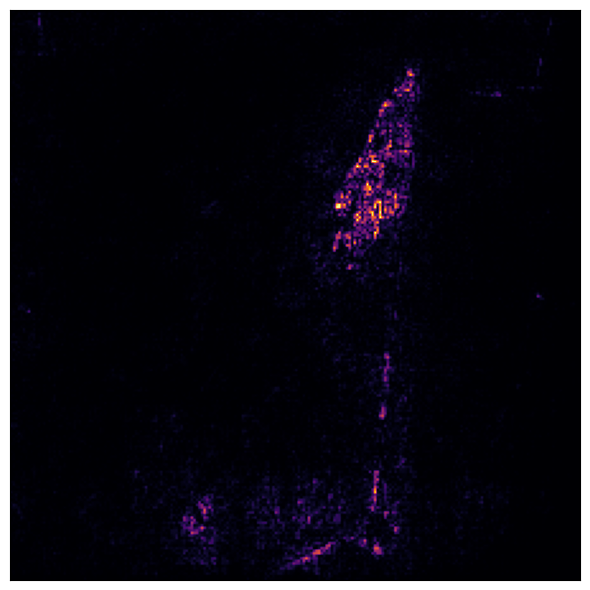

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


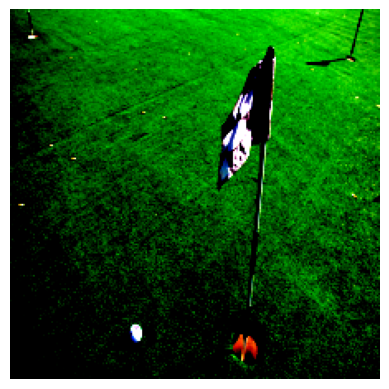

In [249]:
resnet_encoder.eval()
resnet_classifier.eval()

# create a model for resnet_encoder and resnet_classifier

class Model(nn.Module):
    def __init__(self, encoder, classifier, mask_dict):
        super(Model, self).__init__()
        self.encoder = encoder
        self.classifier = classifier
        self.mask_dict = mask_dict

    def forward(self, x):
        x = self.encoder(x, self.mask_dict)
        x = self.classifier(x)
        return x

resnet_encoder.cpu()
resnet_classifier.cpu()
mymodel = Model(resnet_encoder, resnet_classifier, mask_dict)

images, labels = next(iter(train_loader_source))  # Get a batch of images and labels
# find sample in class 1
classidx = 8
idx = (labels == classidx).nonzero()[0].item()
print(idx)

input_img = images[idx].unsqueeze(0) 
integrated_gradients = IntegratedGradients(mymodel)

outputs = mymodel(input_img)

target_class = labels[idx].item()
print(outputs, target_class)
# Compute the integrated gradients attribution
attributions_ig = integrated_gradients.attribute(input_img, target=target_class, n_steps=200)

# Adjust the image and attribution shapes from (channels, height, width) to (height, width, channels)
input_img_np = input_img.squeeze().cpu().detach().permute(1, 2, 0).numpy()
attributions_ig_np = attributions_ig.squeeze().cpu().detach().permute(1, 2, 0).numpy()

# Use Captum's visualization tools to display the attributions on the image
fig, _ = viz.visualize_image_attr_multiple(attributions_ig_np, input_img_np, 
                                  ["heat_map"], 
                                  ["absolute_value"], 
                                  cmap='inferno', show_colorbar=False)
fig.savefig(f'../../imgs/heatmap-source-{case}.jpeg', dpi=1200)
plt.close(fig)

# visualize the original image
plt.imshow(input_img_np)
plt.axis('off')
plt.savefig(f'../../imgs/orginal-source.jpeg', dpi=1200)

In [123]:
# Assuming `images` is a batch of images with shape [10, 3, 224, 224]
# And `model` is your trained model
model.eval()
images, labels = next(iter(train_loader_source)) 
outputs = model(images)
targets = outputs.argmax(dim=1)

integrated_gradients = IntegratedGradients(model)
attributions_igs = [integrated_gradients.attribute(images[i].unsqueeze(0), target=targets[i], n_steps=200) for i in range(10)]


In [86]:
# Convert images and attributions to a suitable format for visualization
# This often involves moving data to CPU, detaching from gradients, and converting to numpy
processed_images = [image.cpu().detach().numpy().transpose(1, 2, 0) for image in images]
processed_attributions = [attribution.cpu().detach().numpy().squeeze().transpose(1, 2, 0) for attribution in attributions_igs]


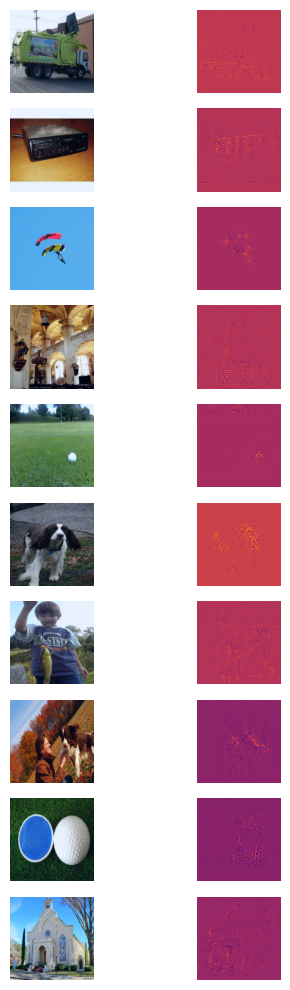

In [87]:
def normalize_image(image):
    image = image - image.min()
    image = image / image.max()
    return image

fig, axs = plt.subplots(nrows=10, ncols=2, figsize=(5, 10))

for i in range(10):
    img = normalize_image(processed_images[i])
    attr = np.mean(processed_attributions[i], axis=2)  # Assuming you want to aggregate attribution across channels

    axs[i, 0].imshow(img)
    axs[i, 0].axis('off')
    axs[i, 1].imshow(attr, cmap='inferno')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [45]:
# visualize the pruning ratio for each layer base on the mask
for name, param in mask_dict.items():
    # check only the convolutional layers
    if 'conv' in name and 'weight' in name:
        print(f'Layer {name} has {torch.sum(param==0).item()/param.numel():.2%} sparsity')

Layer features.4.0.conv1.weight has 28.12% sparsity
Layer features.4.0.conv2.weight has 28.30% sparsity
Layer features.4.1.conv1.weight has 28.77% sparsity
Layer features.4.1.conv2.weight has 28.46% sparsity
Layer features.5.0.conv1.weight has 39.38% sparsity
Layer features.5.0.conv2.weight has 41.11% sparsity
Layer features.5.1.conv1.weight has 42.00% sparsity
Layer features.5.1.conv2.weight has 41.34% sparsity
Layer features.6.0.conv1.weight has 54.88% sparsity
Layer features.6.0.conv2.weight has 59.44% sparsity
Layer features.6.1.conv1.weight has 63.13% sparsity
Layer features.6.1.conv2.weight has 63.72% sparsity
Layer features.7.0.conv1.weight has 77.22% sparsity
Layer features.7.0.conv2.weight has 88.54% sparsity
Layer features.7.1.conv1.weight has 90.36% sparsity
Layer features.7.1.conv2.weight has 94.75% sparsity


In [47]:
# visualize the pruning ratio for each layer base on the mask
for name, param in mask_dict.items():
    # check only the convolutional layers
    if 'conv' in name and 'weight' in name:
        print(f'Layer {name} has {torch.sum(param==0).item()/param.numel():.2%} sparsity')

Layer features.4.0.conv1.weight has 28.48% sparsity
Layer features.4.0.conv2.weight has 28.66% sparsity
Layer features.4.1.conv1.weight has 29.44% sparsity
Layer features.4.1.conv2.weight has 29.29% sparsity
Layer features.5.0.conv1.weight has 40.18% sparsity
Layer features.5.0.conv2.weight has 41.57% sparsity
Layer features.5.1.conv1.weight has 42.14% sparsity
Layer features.5.1.conv2.weight has 41.86% sparsity
Layer features.6.0.conv1.weight has 52.86% sparsity
Layer features.6.0.conv2.weight has 56.32% sparsity
Layer features.6.1.conv1.weight has 58.60% sparsity
Layer features.6.1.conv2.weight has 60.63% sparsity
Layer features.7.0.conv1.weight has 74.82% sparsity
Layer features.7.0.conv2.weight has 89.37% sparsity
Layer features.7.1.conv1.weight has 91.88% sparsity
Layer features.7.1.conv2.weight has 96.23% sparsity


In [ ]:
from captum.attr import LayerConductance
from captum.attr import visualization as viz

# Assuming `model` is your model and `layer` is the layer you're interested in
lc = LayerConductance(model, model.encoder.features.7.0.conv1)

# Assuming `input_tensor` is your pre-processed input tensor
# You might need to add a batch dimension if your model expects it
attributions = lc.attribute(input_tensor, target=label_index)

viz.visualize_image_attr(attributions[0].cpu().detach().numpy(), method="heat_map", sign="all")


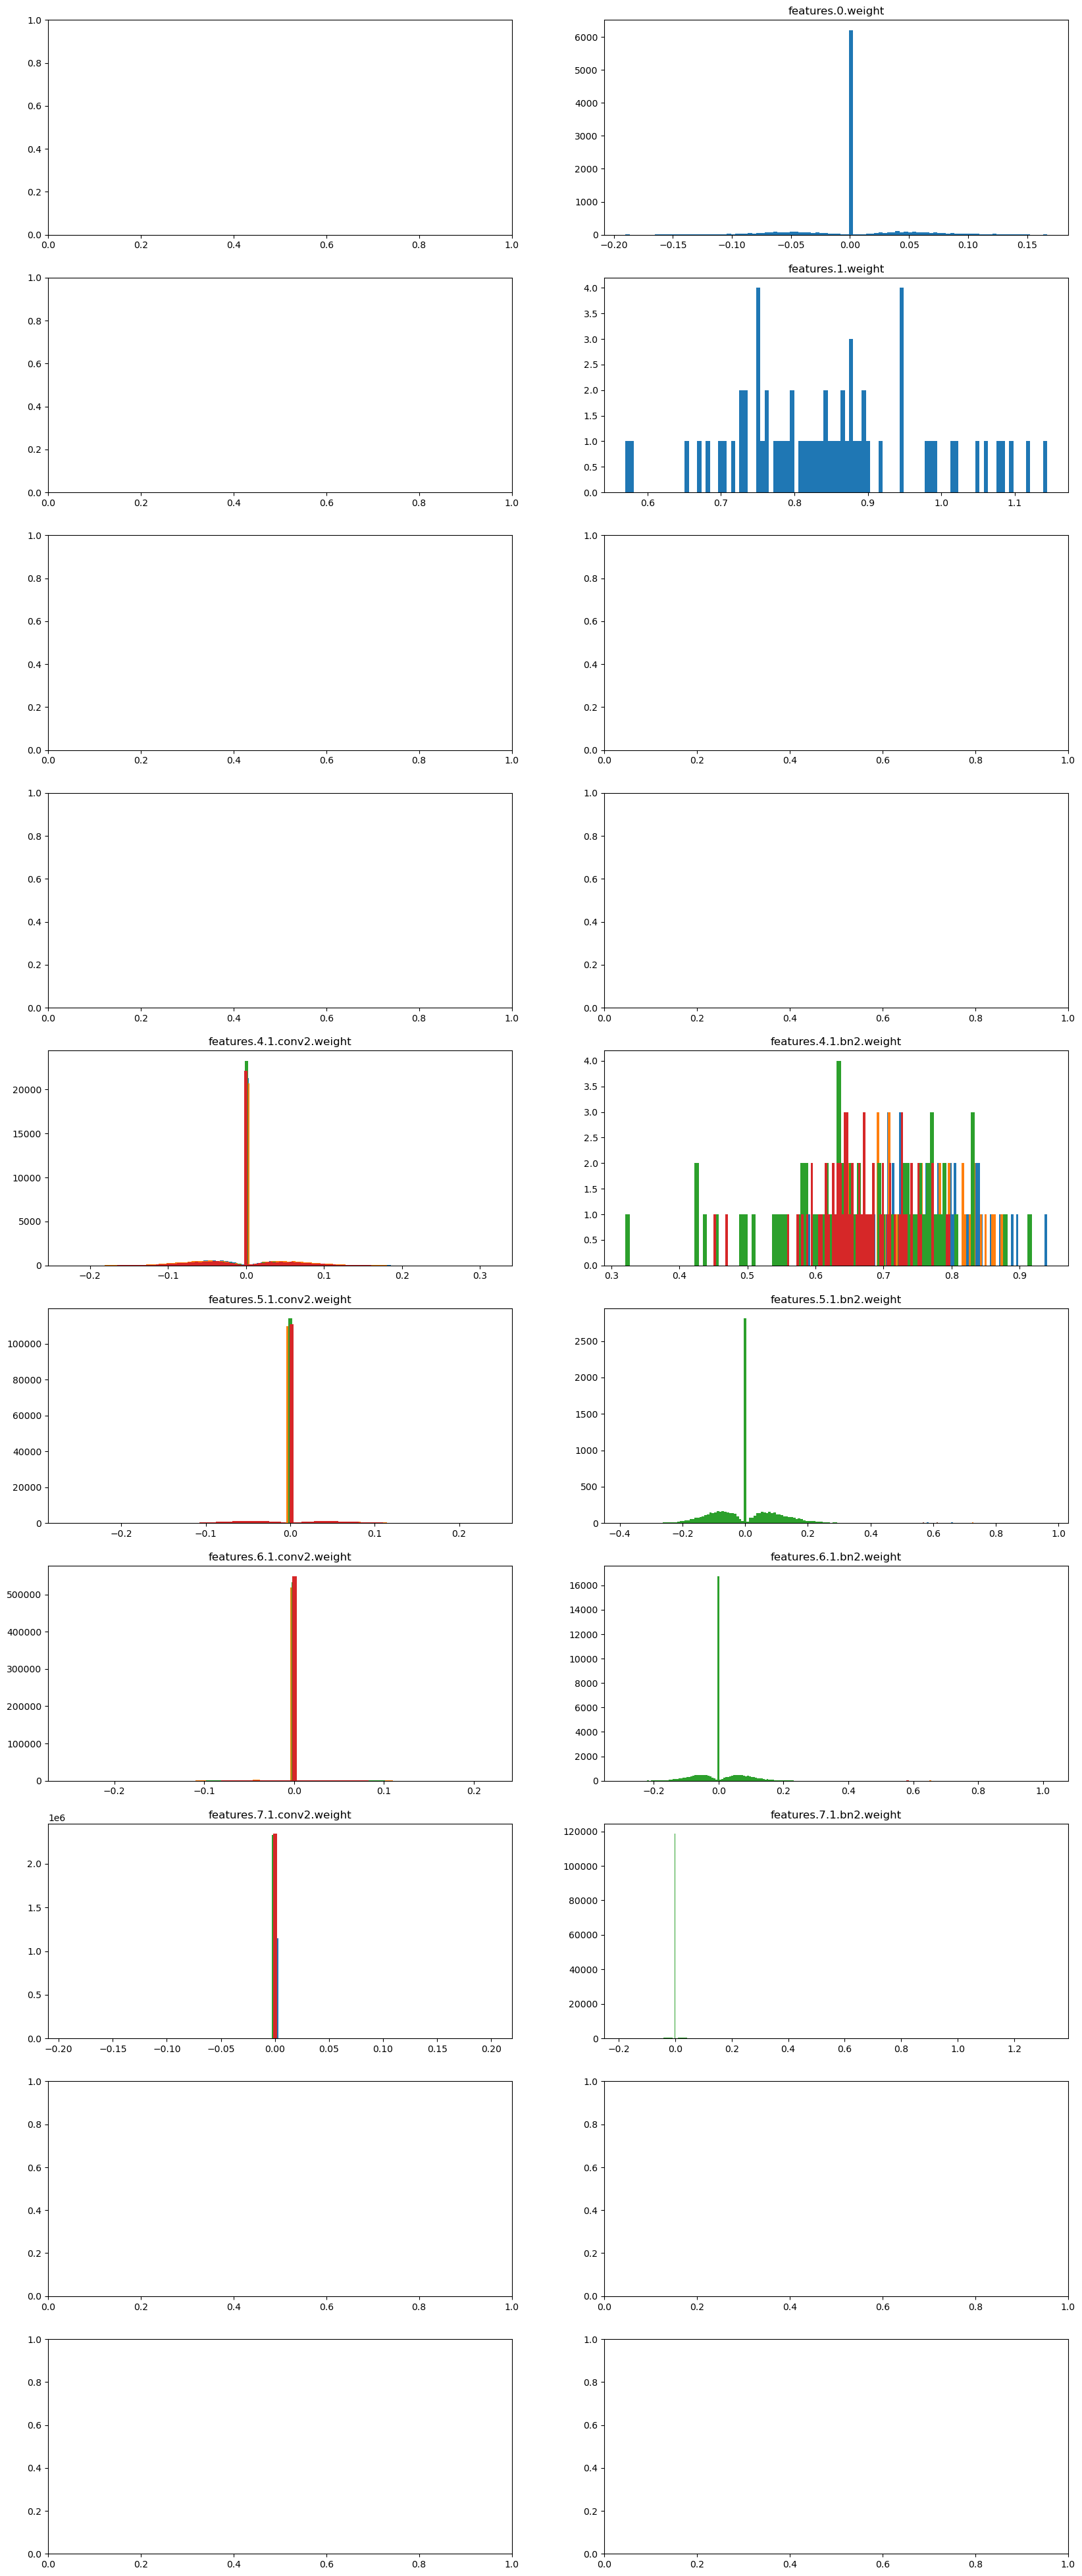

In [157]:
# The weight pruned for each layer in the encoder, visualize the histogram based on resnet_encoder 
import matplotlib.pyplot as plt

# view it in grid 
fig, axes = plt.subplots(10, 2, figsize=(20, 50))
for name, param in resnet_encoder.named_parameters():
    # only view the weights
    if 'weight' in name:
        i = int(name.split('.')[1])
        j = 0 if 'conv' in name else 1
        axes[i, j].hist(param.cpu().detach().numpy().flatten(), bins=100)
        axes[i, j].set_title(name)
plt.show()
